In [1]:
%load_ext autoreload
%autoreload 2
%env CUDA_VISIBLE_DEVICES=5

import matplotlib.pyplot as plt
import pickle
import os
import numpy as np
from pykeops.torch import LazyTensor
import torch
import matplotlib.lines as mlines
import matplotlib
import umap
from vis_utils.loaders import load_pendigits
from vis_utils.utils import  inv_square_sim_dist, compute_low_dim_sims, get_target_sim, get_UMAP_push_weight
from vis_utils.plot import plot_all_losses, histogram_keops


env: CUDA_VISIBLE_DEVICES=5


**PenDigits** is a rather small dataset (<10k samples) of hand-written digits. Their apparent clusters are corresponding to the actual numbers, and we assume them to be easily distinguished.

In [2]:
root_path = "/export/ial-nfs/user/sdamrich/nce_data"
fig_path = "/export/ial-nfs/user/sdamrich/nce_data/figures"

# get data
x, y  = load_pendigits(root_path)

# UMAP


In [46]:
# parameters for all methods
n_epochs = 750
seed = 0
lr = 1.0

In [47]:
filename = os.path.join(root_path, "pendigits", f"umap_n_epochs_{n_epochs}_lr_{lr}_seed_{seed}.pkl")
try:
    with open(filename, "rb") as file:
        umapperns_after = pickle.load(file)
        embd_after = umapperns_after.embedding_
except FileNotFoundError:
    umapperns_after = umap.UMAP(n_neighbors=15,
                                n_epochs=n_epochs,
                                log_losses="after",
                                log_embeddings=True,
                                log_norm=True,
                                log_kl=True,
                                random_state=seed,
                                verbose=True,
                                learning_rate=lr)
    embd_after = umapperns_after.fit_transform(x)
    with open(filename, "wb") as file:
        pickle.dump(umapperns_after, file, pickle.HIGHEST_PROTOCOL)

graph = umapperns_after.graph_.tocoo()
target_sim_inv_sq_pos = get_target_sim(graph, sim_func="inv_sq")



Mon Jan 24 17:09:25 2022 Building and compiling search function


In [5]:
cmap = matplotlib.cm.get_cmap("tab10")


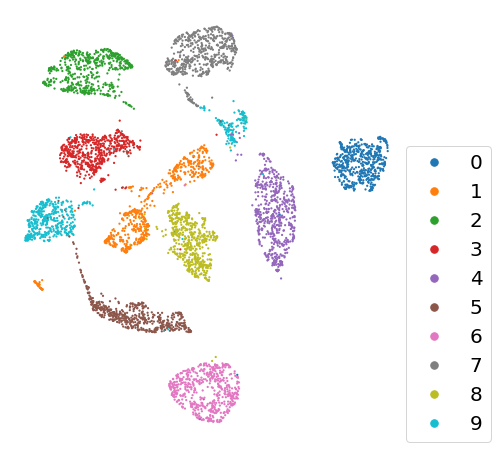

In [103]:
epoch=-1
plt.figure(figsize=(8,8))
plt.scatter(*umapperns_after.aux_data["embeddings"][epoch].T, c=y, s=20, marker=".", cmap="tab10", edgecolor="none", alpha=1.0)

plt.axis("off")
plt.gca().set_aspect("equal")

# dummy dots for legend
dots = []
for i in range(len(np.unique(y))):
    dot = mlines.Line2D([], [], color=cmap(i), marker='.', linestyle="none", markersize=15, label=np.unique(y)[i])
    dots.append(dot)

plt.legend(handles=dots, prop={'size': 20}, loc=(1,0))

plt.savefig(os.path.join(fig_path,
                         f"umap_pendigits_n_epochs_{n_epochs}_lr_{lr}_seed_{seed}.png"),
            bbox_inches = 'tight',
            pad_inches = 0,
            dpi=300)

## Losses

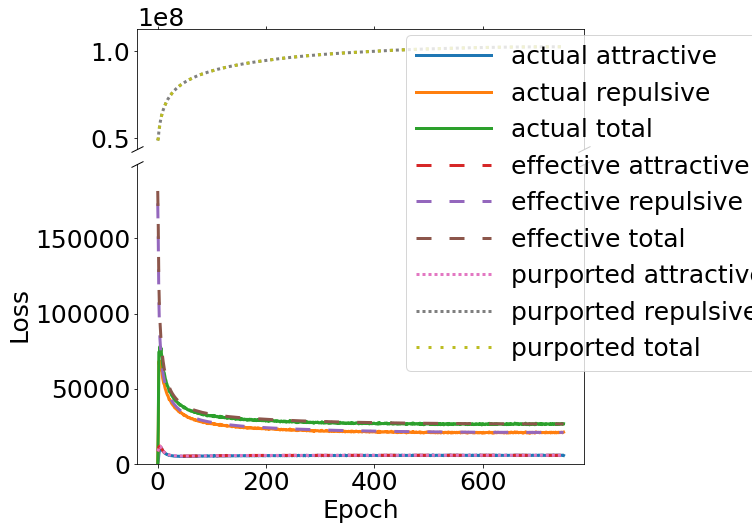

In [22]:
_ = plot_all_losses(umapperns_after.aux_data)

In [23]:
umapperns_after.aux_data["loss_a_exp"][-1] + umapperns_after.aux_data["loss_r_exp"][-1]

26519.73437186432

2.7686070690636004


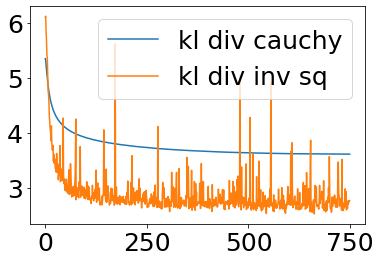

In [24]:
plt.plot(umapperns_after.aux_data["kl_cauchy"], label="kl div cauchy")
plt.plot(umapperns_after.aux_data["kl_inv_sq"], label="kl div inv sq")
plt.legend()
print(umapperns_after.aux_data["kl_inv_sq"][-1])

## Normalisations

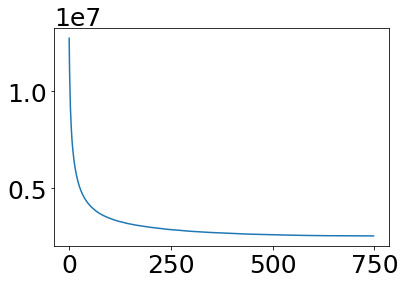

In [25]:
plt.plot(umapperns_after.aux_data["norm_cauchy"][1:])

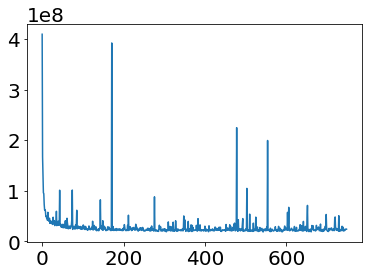

In [104]:
plt.plot(umapperns_after.aux_data["norm_inv_sq"][1:])

[0.58091336]


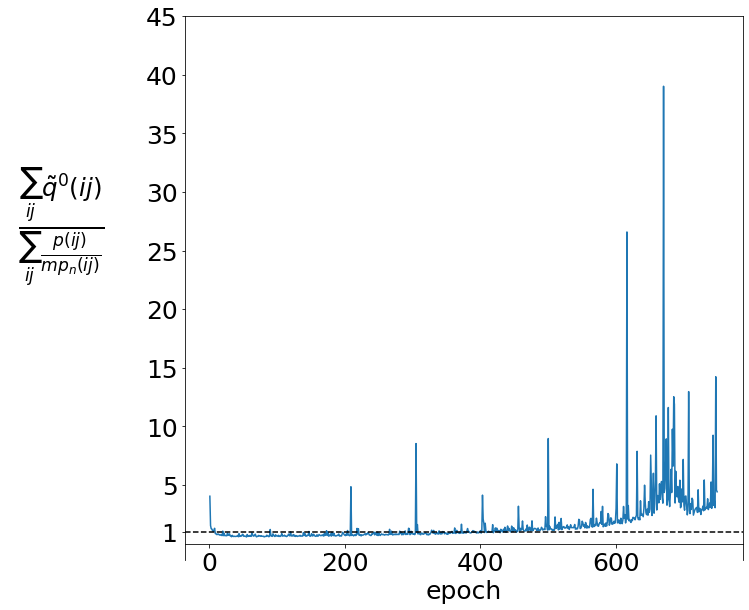

In [48]:
# divide norm of inverse squared similarities by the norm of the target similarities, which are in this case p(ij) / p_n(ij)
# --> should be relatively close to one
plt.figure(figsize=(10,10))
plt.rcParams['font.size'] = 25
start = 1
epochs = np.arange(len(umapperns_after.aux_data["norm_inv_sq"]))[start:]

min_rel_norm = (umapperns_after.aux_data["norm_inv_sq"] / target_sim_inv_sq_pos.sum()).min().cpu().numpy()

plt.plot(epochs, (umapperns_after.aux_data["norm_inv_sq"] / target_sim_inv_sq_pos.sum())[start:])
plt.axhline(y=1 , linestyle="dashed", c="k")

#plt.gca().spines['left'].set_position("zero")
plt.gca().spines['bottom'].set_position("zero")
y_ticks = list(plt.yticks()[0])
y_ticks.remove(0.0)
if (-10.0 in y_ticks):
    y_ticks.remove(-10.0)

if (-20. in y_ticks):
    y_ticks.remove(-20.0)

if (-5.0 in y_ticks):
    y_ticks.remove(-5.0)


_ = plt.yticks(y_ticks + [1])

plt.xlabel("epoch")
plt.ylabel("relative normalization")
print(min_rel_norm)


plt.xlabel("epoch")
plt.ylabel(r" $ \frac{\sum_{ij}\tilde{q}^0(ij)}{\sum_{ij}\frac{p(ij)}{mp_n(ij)}} $", rotation=0, labelpad = 90, size = 35)


plt.savefig(os.path.join(fig_path,
                         f"umap_pen_digits_rel_norm_n_epochs_{n_epochs}_lr_{lr}_seed_{seed}_start_{start}.png"),
            bbox_inches = 'tight',
            pad_inches = 0,
            dpi=300)

## Various historgrams

In [5]:
lazy_embd_i = LazyTensor(torch.tensor(embd_after[:, None, :],
                                      device="cuda",
                                      dtype=torch.float))
lazy_embd_j = LazyTensor(torch.tensor(embd_after[None],
                                      device="cuda",
                                      dtype=torch.float))

dists_sq = ((lazy_embd_i - lazy_embd_j)**2).sum(-1)
dists = dists_sq.sqrt()

[pyKeOps] Compiling libKeOpstorch6dabca085b in /export/home/sdamrich/.cache/pykeops-1.5-cpython-38-gpu5:
       formula: Max_Reduction(((Sum(Square((Var(0,2,0) - Var(1,2,1)))) * (Var(5,1,2) - Step((Var(4,1,2) - Abs((Var(2,1,0) - Var(3,1,1))))))) + (Step((Var(4,1,2) - Abs((Var(2,1,0) - Var(3,1,1))))) * Var(6,1,2))),1)
       aliases: Var(0,2,0); Var(1,2,1); Var(2,1,0); Var(3,1,1); Var(4,1,2); Var(5,1,2); Var(6,1,2); 
       dtype  : float32
... 
Done.
[pyKeOps] Compiling libKeOpstorch2c8b9836a6 in /export/home/sdamrich/.cache/pykeops-1.5-cpython-38-gpu5:
       formula: Min_Reduction(((Sum(Square((Var(0,2,0) - Var(1,2,1)))) * (Var(5,1,2) - Step((Var(4,1,2) - Abs((Var(2,1,0) - Var(3,1,1))))))) + (Step((Var(4,1,2) - Abs((Var(2,1,0) - Var(3,1,1))))) * Var(6,1,2))),1)
       aliases: Var(0,2,0); Var(1,2,1); Var(2,1,0); Var(3,1,1); Var(4,1,2); Var(5,1,2); Var(6,1,2); 
       dtype  : float32
... 
Done.
[pyKeOps] Compiling libKeOpstorch02b01c0c2c in /export/home/sdamrich/.cache/pykeops-1.5-cp

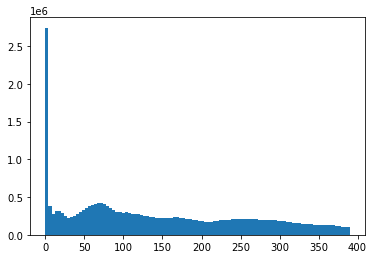

In [6]:
hist_d_sq, bins_d_sq = histogram_keops(dists_sq,
                                       hist_range=(0, 390),
                                       no_diag=True)

_, _, _ = plt.hist(bins_d_sq[:-1],
                   bins_d_sq,
                   weights=hist_d_sq,
                   alpha=1.0,
                   label="squared_dists")

[pyKeOps] Compiling libKeOpstorchcc90a8dd18 in /export/home/sdamrich/.cache/pykeops-1.5-cpython-38-gpu5:
       formula: Max_Reduction(((Sqrt(Sum(Square((Var(0,2,0) - Var(1,2,1))))) * (Var(5,1,2) - Step((Var(4,1,2) - Abs((Var(2,1,0) - Var(3,1,1))))))) + (Step((Var(4,1,2) - Abs((Var(2,1,0) - Var(3,1,1))))) * Var(6,1,2))),1)
       aliases: Var(0,2,0); Var(1,2,1); Var(2,1,0); Var(3,1,1); Var(4,1,2); Var(5,1,2); Var(6,1,2); 
       dtype  : float32
... 
Done.
[pyKeOps] Compiling libKeOpstorch6c9e95db9c in /export/home/sdamrich/.cache/pykeops-1.5-cpython-38-gpu5:
       formula: Min_Reduction(((Sqrt(Sum(Square((Var(0,2,0) - Var(1,2,1))))) * (Var(5,1,2) - Step((Var(4,1,2) - Abs((Var(2,1,0) - Var(3,1,1))))))) + (Step((Var(4,1,2) - Abs((Var(2,1,0) - Var(3,1,1))))) * Var(6,1,2))),1)
       aliases: Var(0,2,0); Var(1,2,1); Var(2,1,0); Var(3,1,1); Var(4,1,2); Var(5,1,2); Var(6,1,2); 
       dtype  : float32
... 
Done.
[pyKeOps] Compiling libKeOpstorch7262d4772d in /export/home/sdamrich/.cache/py

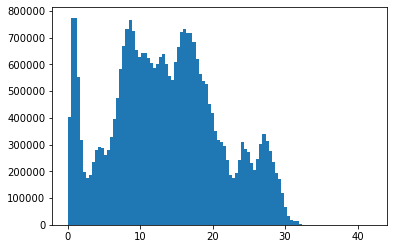

In [7]:
hist_d, bins_d = histogram_keops(dists,
                                 hist_range=(0, 42),
                                 no_diag=True)

_, _, _ = plt.hist(bins_d[:-1],
                   bins_d,
                   weights=hist_d,
                   alpha=1.0,
                   label="squared_dists")

In [8]:
a_lt = LazyTensor(torch.tensor(umapperns_after._a, device="cuda", dtype=torch.float))
b_lt = LazyTensor(torch.tensor(umapperns_after._b, device="cuda", dtype=torch.float))
sq_sim_lt = a_lt * dists_sq**b_lt

hist_sim_sq, bins_sim_sq = histogram_keops(sq_sim_lt,
                                           hist_range=(0,1230),
                                           no_diag=True,
                                           bins=1000)

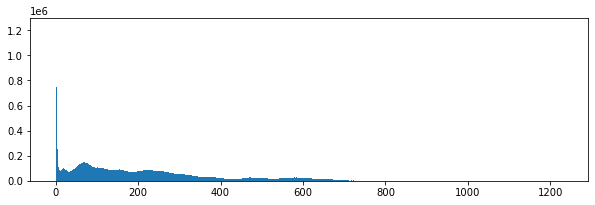

In [9]:
plt.figure(figsize=(10,3))
_, _, _ = plt.hist(bins_sim_sq[:-1],
                   bins_sim_sq,
                   weights=hist_sim_sq,
                   alpha=1.0,
                   label="sim_sq")
#plt.yscale("log")

In [19]:
a_lt = LazyTensor(torch.tensor(umapperns_after._a, device="cuda", dtype=torch.float))
b_lt = LazyTensor(torch.tensor(umapperns_after._b, device="cuda", dtype=torch.float))
inv_sq_sim_lt = inv_square_sim_dist(dists_sq,
                                    a=a_lt,
                                    b=b_lt,
                                    squared=True,
                                    eps=1e-4)
hist_inv_sq, bins_inv_sq = histogram_keops(inv_sq_sim_lt,
                                           hist_range=(0, 10000),
                                           no_diag=True,
                                           bins=100)

inv_sq_sim_lt_low_eps = inv_square_sim_dist(dists_sq,
                                    a=a_lt,
                                    b=b_lt,
                                    squared=True,
                                    eps=1e-10)
hist_inv_sq_low_eps, bins_inv_sq = histogram_keops(inv_sq_sim_lt_low_eps,
                                           hist_range=(0, 10000),
                                           no_diag=True,
                                           bins=100)

Historgram counts should match product of input tensor shapes, but are 31584400 and 31584256.


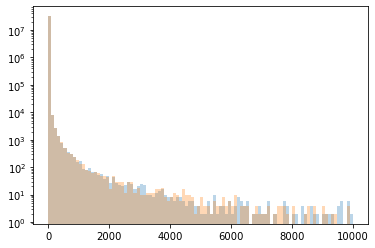

In [22]:
_, _, _ = plt.hist(bins_inv_sq[:-1],
                   bins_inv_sq,
                   weights=hist_inv_sq,
                   alpha=0.3,
                   label="inv_sq")
_, _, _ = plt.hist(bins_inv_sq[:-1],
                   bins_inv_sq,
                   weights=hist_inv_sq_low_eps,
                   alpha=0.3,
                   label="inv_sq")

plt.yscale("log")

### Only on pos high-dim

In [41]:
inv_sq_sim_pos = compute_low_dim_sims(embedding1=umapperns_after.aux_data["embeddings"][200][graph.row],  # embd_after[graph.row],
                                      embedding2=umapperns_after.aux_data["embeddings"][200][graph.col],  # embd_after[graph.col],
                                      a=umapperns_after._a,
                                      b=umapperns_after._b,
                                      sim_func="inv_sq",
                                      eps=1e-10) # not much change in the histograms for 1e-4 - 1e-10

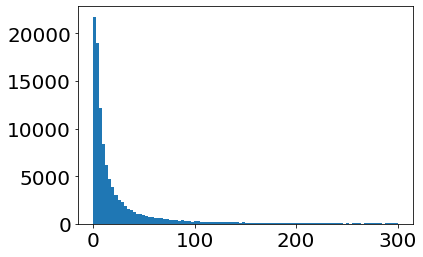

In [42]:
hist_inv_sq_pos, bins_inv_sq_pos = np.histogram(inv_sq_sim_pos,
                                       bins=100,
                                       range=(0, 300))

_, _, _ = plt.hist(bins_inv_sq_pos[:-1], bins_inv_sq_pos, weights=hist_inv_sq_pos)
#plt.yscale("log")

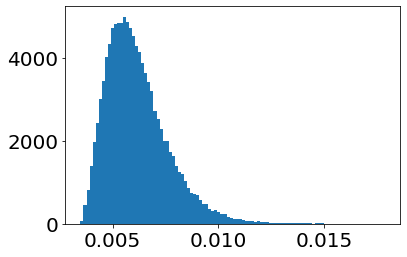

In [43]:
_, _, _ = plt.hist(get_UMAP_push_weight(graph, negative_sample_rate=5, push_tail=True)[0].data, bins=100)

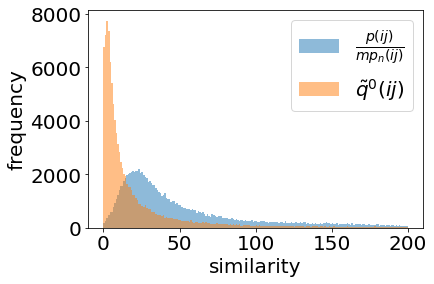

In [44]:
plt.figure()
plt.rcParams['font.size'] = 20

_, _, _ = plt.hist(target_sim_inv_sq_pos.data, bins=200, range= (0, 200), alpha=0.5, label=r"$\frac{p(ij)}{mp_n(ij)}$")
_, _, _ = plt.hist(inv_sq_sim_pos, bins=200, range= (0,200), alpha=0.5, label=r"$\tilde{q}^0(ij)$")
#plt.yscale("log")
plt.ylabel("frequency")
plt.xlabel("similarity")
plt.legend()

#plt.savefig(os.path.join(fig_path,
#                         f"umap_pendigits_hist_pos_n_epochs_{n_epochs}_lr_{lr}_seed_{seed}.png"),
#            bbox_inches = 'tight',
#            pad_inches = 0,
#            dpi=300)

In [110]:
inv_sq_sim_pos.max()

1275260.9

In [ ]:
umapperns_after.aux_data["norm_inv_sq"][-1]

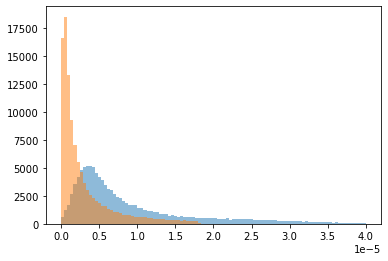

In [79]:
_, _, _ = plt.hist(target_sim_inv_sq_pos.data / target_sim_inv_sq_pos.sum(), bins=100, range= (0, 0.00004), alpha=0.5)
_, _, _ = plt.hist(inv_sq_sim_pos / umapperns_after.aux_data["norm_inv_sq"][-500].cpu().numpy(), bins=100, range= (0,0.00004), alpha=0.5)
#plt.yscale("log")


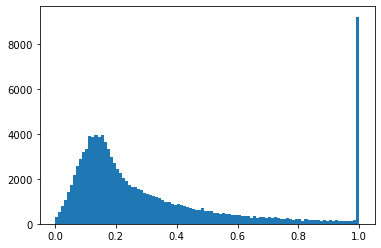

In [43]:
_, _, _ = plt.hist(graph.data, bins= 100)

In [53]:
noise = get_UMAP_push_weight(graph, negative_sample_rate=5, push_tail=True)[0].data

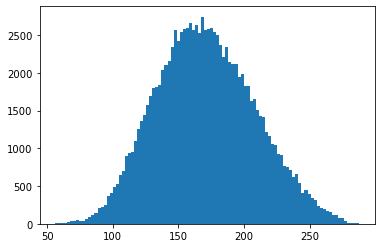

In [54]:
_, _, _ = plt.hist(noise**-1, bins= 100)

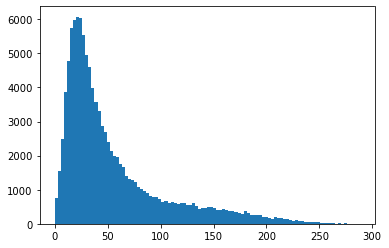

In [55]:
_, _, _ = plt.hist(graph.data / noise, bins =100)

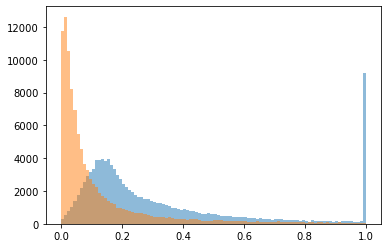

In [57]:
_, _, _ = plt.hist(graph.data, bins=100, range= (0, 1), alpha=0.5)
_, _, _ = plt.hist(inv_sq_sim_pos * noise, bins=100, range= (0,1), alpha=0.5)
#plt.yscale("log")

In [61]:
import scipy.sparse
from vis_utils.utils import kNN_graph, sort_sims_by_proximity, compute_normalization

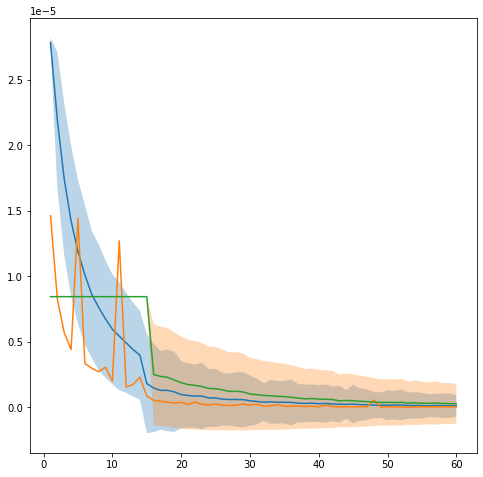

In [69]:

knn_graph = kNN_graph(x.astype("float"),
                      15,
                      metric="euclidean").cpu().numpy().flatten()
knn_graph = scipy.sparse.coo_matrix((np.ones(len(x) * 15),
                                     (np.repeat(np.arange(x.shape[0]),
                                                15),
                                      knn_graph)),
                                    shape=(len(x), len(x)))
sknn_graph = knn_graph.maximum(knn_graph.transpose()).tocoo()


sorted_bin_sims = sort_sims_by_proximity(sknn_graph, k=4 * 15, x=x)
sorted_bin_sims /= sknn_graph.sum()

sorted_umap_sims = sort_sims_by_proximity(graph, k=4*15, x=x)
sorted_umap_sims /= graph.sum()


inv_sq_sim_pos_sparse = graph.copy()
inv_sq_sim_pos_sparse.data = inv_sq_sim_pos

sorted_embd_sims = sort_sims_by_proximity(inv_sq_sim_pos_sparse, k=4*15, x=x)
sorted_embd_sims /= compute_normalization(umapperns_after.aux_data["embeddings"][-1],
                                          sim_func="inv_sq",
                                          no_diag=True,
                                          a=umapperns_after._a,
                                          b=umapperns_after._b,
                                          eps=float(np.finfo(float).eps)).cpu().numpy()

plt.figure(figsize=(8, 8))
sorted_umap_sims_mean = sorted_umap_sims.mean(0)
sorted_umap_sims_std = sorted_umap_sims.std(0)
plt.plot(np.arange(len(sorted_umap_sims_mean)) + 1, sorted_umap_sims_mean)
plt.fill_between(np.arange(len(sorted_umap_sims_mean)) + 1,
                 sorted_umap_sims_mean - sorted_umap_sims_std,
                 sorted_umap_sims_mean + sorted_umap_sims_std,
                 alpha=0.3)


sorted_embd_sims_mean = sorted_embd_sims.mean(0)
sorted_embd_sims_std = sorted_embd_sims.std(0)
plt.plot(np.arange(len(sorted_embd_sims_mean)) + 1, sorted_embd_sims_mean)
#plt.fill_between(np.arange(len(sorted_embd_sims_mean)) + 1,
#                 sorted_embd_sims_mean - sorted_embd_sims_std,
#                 sorted_embd_sims_mean + sorted_embd_sims_std,
#                 alpha=0.3)


sorted_bin_sims_mean = sorted_bin_sims.mean(0)
sorted_bin_sims_std = sorted_bin_sims.std(0)
plt.plot(np.arange(len(sorted_bin_sims_mean)) + 1, sorted_bin_sims_mean)
plt.fill_between(np.arange(len(sorted_umap_sims_mean)) + 1,
                 sorted_bin_sims_mean - sorted_bin_sims_std,
                 sorted_bin_sims_mean + sorted_bin_sims_std,
                 alpha=0.3)

In [65]:
inv_sq_sim_pos.shape

(110534,)